# Introduction

This article belongs to the series "Probabilistic Deep Learning". This weekly series covers probabilistic approaches to deep learning. The main goal is to extend deep learning models to quantify uncertainty, i.e. know what they do not know.

The frequentist approach to statistics is based on the idea of repeated sampling and long-run relative frequency. It involves constructing hypotheses about a population and testing them using sample data. On the other hand, the Bayesian approach is based on subjective probability and involves updating an initial belief about a population using collected data. Both methods have their strengths and limitations and which one to use depends on the problem and analysis goals. In this article, we will explore the differences between the frequentist and the Bayesian approach and discuss how they can be implemented using TensorFlow and TensorFlow Probability.

# Frequentist vs. Bayesian Approach to Problems
Frequentist statistics and Bayesian statistics are two main approaches to statistical inference, which is the process of using data to draw conclusions about a population. Both approaches are used to estimate unknown quantities, make predictions, and test hypotheses, but they differ in their interpretation of probability and how they incorporate prior knowledge and evidence.

In frequentist statistics, probability is interpreted as the long-run relative frequency of an event in an infinite number of trials. This approach is based on the idea that the true value of a population parameter is fixed, but is unknown and must be estimated from data. In this framework, statistical inferences are drawn from the observed data by making assumptions about the underlying data-generating process and using techniques such as point estimation, confidence intervals, and hypothesis testing.

On the other hand, Bayesian statistics interprets probability as a measure of belief or degree of certainty about an event. This approach allows for the incorporation of prior knowledge and evidence into statistical analysis through the use of Bayes' theorem. In this framework, the true value of a population parameter is treated as a random variable and is updated as new data is collected. This results in a full distribution over the parameter space, known as a posterior distribution, which can be used to make probabilistic predictions and to quantify uncertainty.

One key difference between the two approaches is how they handle uncertainty. In frequentist statistics, uncertainty is quantified through the use of confidence intervals, which provide an estimate of the likely range of the true population parameter based on the observed data. In Bayesian statistics, uncertainty is represented by the full posterior distribution, which allows for a more complete characterization of the uncertainty surrounding the true value of the parameter.

Another difference is that Bayesian statistics allows for the incorporation of prior knowledge, which can be particularly useful in cases where there is limited data or when the data-generating process is complex. However, the choice of prior distribution can significantly influence the results of a Bayesian analysis, and it is important to choose a prior that is appropriate for the problem at hand.

# The Problem

As an example of applying a frequentist approach to a problem, consider the task of estimating the mean income of a population based on a sample of data. In this case, the goal is to use the sample data to make inferences about the true mean income of the population (we are going to assume that the standard deviation of the income of the population is known for now).

Let's generate some data:

In [6]:
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from scipy.stats import t
import numpy as np

tfd = tfp.distributions

In [7]:
# Sample data
sample_size = 30.
sample_mean = 50000.
sample_stddev = 10000.
sample_data = tfd.Normal(loc=sample_mean, scale=sample_stddev).sample(sample_size)

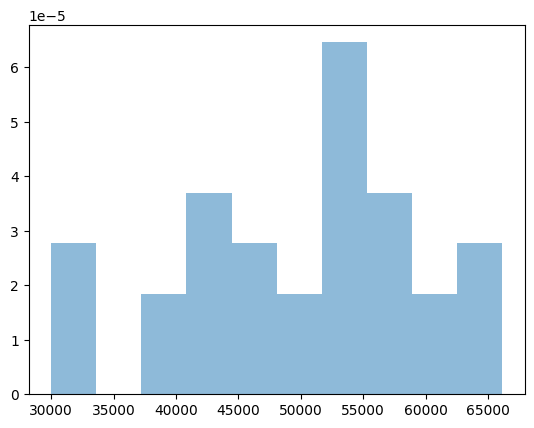

In [8]:
plt.hist(sample_data, density=True, alpha=0.5);


## The Frequentist Way

One way to approach this problem using a frequentist approach is through point estimation. Point estimation involves using a single point estimate, such as the sample mean, to represent the unknown population parameter. The sample mean is a commonly used point estimate for the population mean, and it is calculated as the sum of the sample values divided by the sample size.

The sample mean, $\hat{\mu}$, is a commonly used point estimate for the population mean, $\mu$. It is calculated as the sum of the sample values, $x_1, x_2, ..., x_n$, divided by the sample size, $n$:

$\hat{\mu} = \frac{1}{n} \sum_{i=1}^n x_i$

In [9]:
sample_mean = tf.reduce_mean(sample_data)
sample_mean

<tf.Tensor: shape=(), dtype=float32, numpy=50097.785>

However, point estimates alone do not provide a complete characterization of the uncertainty surrounding the estimate. To quantify this uncertainty, we can use a confidence interval. A confidence interval is an estimate of the likely range of the true population parameter based on the observed data, and it is constructed by adding and subtracting a margin of error to the point estimate. The margin of error is determined by the desired level of confidence and the sample size, and it reflects the variability in the sample data. For example, a 95% confidence interval indicates that we are 95% confident that the true population parameter falls within the interval.

A confidence interval for the population mean is constructed by adding and subtracting a margin of error, $m$, to the point estimate:

$\hat{\mu} \pm m = [\hat{\mu} - m, \hat{\mu} + m]$

The margin of error is determined by the desired level of confidence, $1-\alpha$, and the sample size, $n$. It reflects the variability in the sample data and is typically calculated using the standard error, $SE$, of the point estimate:

$m = t_{1-\frac{\alpha}{2}, n-1} \times SE$

where $t_{1-\frac{\alpha}{2}, n-1}$ is the critical value of the $t$-distribution with $n-1$ degrees of freedom for the desired level of confidence.

The standard error of the sample mean is calculated as the standard deviation of the sample, $\sigma$, divided by the square root of the sample size:

$SE = \frac{\sigma}{\sqrt{n}}$


In [10]:
# Standard error of the sample mean
sample_stddev = tf.math.reduce_std(sample_data)
standard_error = sample_stddev / tf.sqrt(sample_size)

# Margin of error
confidence_level = 0.95
degrees_of_freedom = sample_size - 1
t_distribution = tfp.distributions.StudentT(df=degrees_of_freedom, loc=0., scale=1.)

# t_distribution.quantile() seems to have a bug
t_value = t.ppf(confidence_level+(1-confidence_level)/2, df=sample_size-1)
margin_of_error = t_value * standard_error

confidence_interval_lower = sample_mean - margin_of_error
confidence_interval_upper = sample_mean + margin_of_error
confidence_interval = (confidence_interval_lower.numpy(), confidence_interval_upper.numpy())
confidence_interval

(46550.523, 53645.047)

We can define a helper function to plot our predicting mean and confidence interval overlayed on sampled data.

In [11]:
def visualize_output(sample_data, sample_mean, interval, type_interval):
    plt.hist(sample_data, density=True, alpha=0.5)
    plt.axvline(x=sample_mean, color='r', linestyle='dashed', linewidth=2)
    plt.axvline(x=interval[0], color='g', linewidth=2)
    plt.axvline(x=interval[1], color='g', linewidth=2)
    plt.legend(['Sample Mean', f'{type_interval} interval'])
    plt.show()

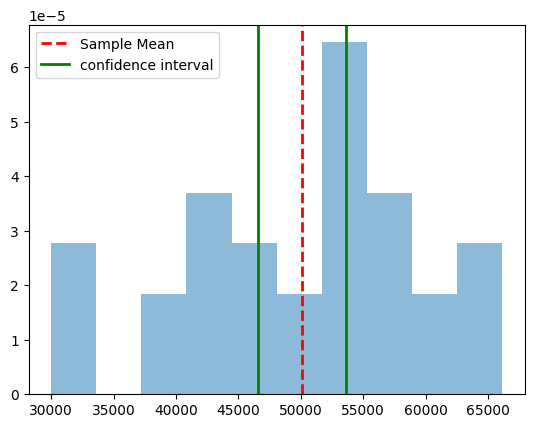

In [12]:
visualize_output(sample_data, sample_mean, confidence_interval, 'confidence')

## The Bayesian Way

As an example of applying a Bayesian approach to a problem, consider the task of estimating the mean income of a population based on a sample of data. In this case, the goal is to use the sample data and any available prior knowledge to make inferences about the true mean income of the population.

One way to approach this problem using a Bayesian approach is through the use of Bayes' theorem, which allows us to update our belief about the value of the population mean income based on the observed data. Bayes' theorem states that the posterior probability of a hypothesis given some data is equal to the prior probability of the hypothesis multiplied by the likelihood of the data given the hypothesis, normalized by the marginal probability of the data. This can be written mathematically as:

$P(\theta|x) = \frac{P(\theta)P(x|\theta)}{P(x)}$

where $\theta$ is the population mean income, $x$ is the observed data (i.e., the sample of income values), and $P(\theta|x)$, $P(x|\theta)$, $P(\theta)$, and $P(x)$ are the posterior probability, likelihood, prior probability, and marginal probability, respectively.

To apply this approach to the income example, we must first specify a prior distribution over the population mean income, $P(\theta)$. This prior distribution represents our belief about the value of the population mean income before we observe the data. The choice of prior distribution will depend on any available prior knowledge and the characteristics of the data-generating process. For example, if we have strong prior knowledge that the population mean income is normally distributed with a mean of $40,000$ and a standard deviation of $5,000$, we could use a normal prior distribution with these parameters.

In [14]:
mu_prior = 40000.
sigma_prior = 5000.
prior = tfd.Normal(loc=mu_prior, scale=sigma_prior)

The likelihood function, $P(x|\theta)$, represents the probability of observing the sample data, $x$, given a particular value of the population mean income, $\theta$. Since the sample data are assumed to be independent and identically distributed (i.i.d.), the likelihood function is simply the product of the individual probability density functions of the sample values. For example, if the sample data are normally distributed with a known standard deviation, $\sigma$, the likelihood function is a normal distribution with mean equal to the population mean income, $\theta$, and standard deviation equal to the sample standard deviation:

$P(x|\theta) = \prod_{i=1}^n \mathcal{N}(x_i|\theta, \sigma)$

In [15]:
mu_likelihood = np.mean(sample_data)
sigma_likelihood = np.std(sample_data)
likelihood = tfd.Normal(loc=np.mean(sample_data), scale=np.std(sample_data))

Next, we use Bayes' theorem to compute the posterior distribution:

$P(\theta|x) = \frac{ \mathcal{N}(\theta)\prod_{i=1}^n \mathcal{N}(x_i|\theta)}{P(x)}$

The posterior distribution can be used to make probabilistic predictions and to quantify the uncertainty surrounding the estimate of the population mean income. For example, we can use the posterior distribution to compute the posterior mean and posterior standard deviation as estimates of the population mean income and the uncertainty around the estimate, respectively.

As we saw above, the posterior distribution is a result of multiplying two Gaussian distributions. For us to accomplish that, we need to introduce one more concept - conjugate distributions. In our case, we have a normal-normal conjugate family which is a parametric family of distributions where the prior distribution and the likelihood function are both normal distributions. This class of models has several attractive properties, including the ability to analytically compute the posterior distribution and the closed-form solution for the maximum a posteriori (MAP) estimate.

The posterior distribution is defined as the distribution of the model parameters (in this case, the mean $\mu$ and standard deviation $\sigma$ of the normal distribution) given the observed data $y$. The mean and standard deviation of the posterior distribution can be calculated using the following equations:

$$\sigma_{\text{post}}^2 = \frac{1}{\frac{n}{\sigma^2} + \frac{1}{\sigma_0^2}}$$


$$\mu_{\text{post}} = \sigma_{\text{post}}^2 \big( \frac{\mu_0}{\sigma_0^2} + \frac{n \mu_l}{\sigma_l^2} \big)$$

where $\mu_0$ and $\sigma_0^2$ are the mean and variance of the prior distribution, respectively, $mu_l$ and $\sigma_l^2$ are the mean and the variance of the likelihood function and $n$ is the sample size.

These equations assume that the prior distribution and the likelihood function are both normal distributions, as is the case in a normal-normal conjugate model. If the prior and likelihood are not normal, or if the posterior distribution does not have a closed-form solution, these parameters can be approximated using techniques such as Markov Chain Monte Carlo (MCMC) sampling.

We are ready to implement our new equations.

In [18]:
# Compute the posterior distribution using Bayes' theorem
var_posterior = 1 / ((sample_size/(sigma_likelihood**2)) + (1/(sigma_prior**2)))
mu_posterior = var_posterior * (mu_prior/(sigma_prior**2) + (sample_size*mu_likelihood)/(sigma_likelihood**2))
posterior = tfd.Normal(mu_posterior, tf.sqrt(var_posterior))
credible_interval = (posterior.quantile(0.025).numpy(), posterior.quantile(0.975).numpy())
credible_interval

(45801.615148780984, 52224.89311258316)

We can see how updating our prior belief with data resulted in our posterior distribution.

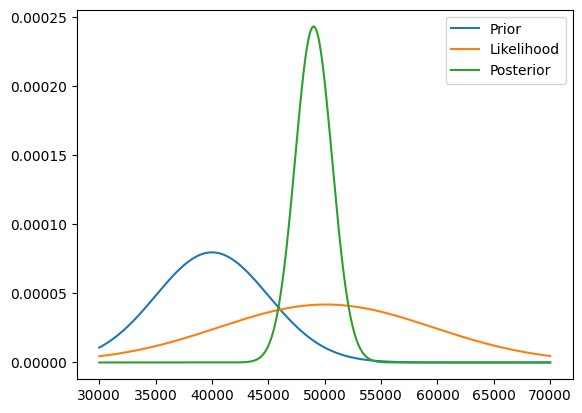

In [19]:
x = np.linspace(30000, 70000, 1000)

y_prior = prior.prob(x)
y_likelihood = likelihood.prob(x)
y_posterior = posterior.prob(x)

plt.plot(x,y_prior, label="Prior")
plt.plot(x,y_likelihood, label="Likelihood")
plt.plot(x,y_posterior, label="Posterior")

plt.legend();

Finally, as we did for the frequentist case, we can plot our estimate for the mean of the population. Notice that we are actually computing the credible interval and not the confidence interval with the Bayesian approach.

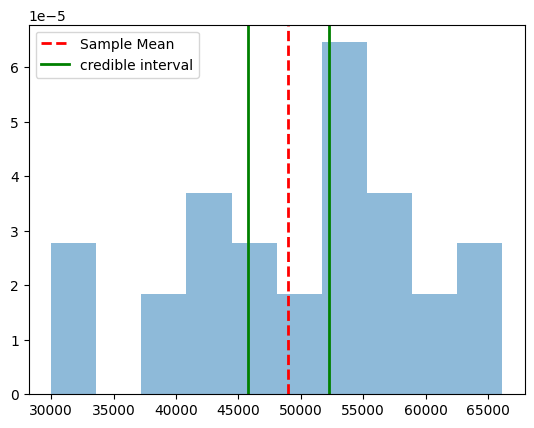

In [20]:
visualize_output(sample_data, posterior.mean(), (posterior.quantile(0.025), posterior.quantile(0.975)), 'credible')

# Conclusion
In conclusion, the frequentist and Bayesian approaches are two different ways of analyzing data and making predictions. The frequentist approach is based on the idea of statistical significance and involves constructing hypotheses about a population and testing them using sample data. The Bayesian approach is based on subjective probability and involves updating an initial belief about a population using collected data.
Using TensorFlow and TensorFlow Probability, we demonstrated how to compute the mean and confidence interval for the frequentist approach and the mean and credible interval for the Bayesian approach. Both approaches can be useful for different types of problems and it is important to understand the strengths and limitations of each one in order to choose the most appropriate method for a given situation.